# Analysis of natural language in the docstrings/comments of Python code

### Docstring and comment extraction from Python code

In [50]:
from text_extraction import get_text

example = """
#general comment
class foo():
    '''
    class docstring
    '''
    
    some_value = 2
    def bar(arg1, arg2):
        ''' function docstring'''
        if arg1 == 2:
            # first comment
            print(arg1)
        else:
            # second comment
            arg2 += 3
        return arg1 + arg2
"""

print(get_text(example))

class docstring
function docstring

general comment first comment second comment


### Language identification

We analyze a 2,000 subset of codeparrot data. 

Note: During docstring extraction, the order of the docstrings in code may not respected, and comments are added at the end without the # sign

In [52]:
from datasets import load_dataset

ds = load_dataset("codeparrot/codeparrot-clean-valid", split="train")

Using custom data configuration codeparrot--codeparrot-clean-valid-acf5bb840ba0029c
Reusing dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-acf5bb840ba0029c/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)


In [58]:
print(get_text(ds[0]["content"], comments=True, clean_comments=True))

Displays a MX Dataset and associated information.

Shows a full (hundreds of images) dataset its metadata and a list
of associated files with the option to show metadata of each file
and ways to download those files.  With write permission this page
also allows uploading and metadata editing.

Settings for this view:
INSTALLED_APPS += ("tardis.apps.mx_views",)
DATASET_VIEWS = [("http://synchrotron.org.au/views/dataset/full",
                  "tardis.apps.mx_views.views.view_full_dataset"),]

 pagination was removed by someone in the interface but not here. need to fix. If page request (9999) is out of range, deliver last page of results. take 4 evenly spaced images from the set


In [57]:
print(ds[0]["content"])

from django.conf import settings
from django.core.paginator import Paginator, InvalidPage, EmptyPage
from django.http import HttpResponse

from tardis.tardis_portal.auth import decorators as authz
from tardis.tardis_portal.models import Dataset
from tardis.tardis_portal.shortcuts import get_experiment_referer
from tardis.tardis_portal.shortcuts import render_response_index


@authz.dataset_access_required
def view_full_dataset(request, dataset_id):
    """Displays a MX Dataset and associated information.

    Shows a full (hundreds of images) dataset its metadata and a list
    of associated files with the option to show metadata of each file
    and ways to download those files.  With write permission this page
    also allows uploading and metadata editing.

    Settings for this view:
    INSTALLED_APPS += ("tardis.apps.mx_views",)
    DATASET_VIEWS = [("http://synchrotron.org.au/views/dataset/full",
                      "tardis.apps.mx_views.views.view_full_dataset"),]

    """
  

In [59]:
from language_identifier import extract_nl_text, FunctionDatasetModifyingDocuments

In [60]:
dataset = ds.select([i for i in range(2000)])
# extraction of NL
dataset = dataset.map(extract_nl_text)

  0%|          | 0/2000 [00:00<?, ?ex/s]

/Users/loubnabenallal/Desktop/bigcode/text_extraction.py:79: UserWarning: code couldn't be parsed due to compilation failure, no docstring is extracted
  warnings.warn("code couldn't be parsed due to compilation failure, no docstring is extracted")
/Users/loubnabenallal/Desktop/bigcode/text_extraction.py:86: UserWarning: tokenization error, no comment is extracted
  warnings.warn("tokenization error, no comment is extracted")


Two new columns in the dataset: nl_text with a string where the extracted dosctrings and comments are concatenated, nl_size: size of nl_text

In [62]:
dataset

Dataset({
    features: ['repo_name', 'path', 'copies', 'size', 'content', 'license', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated', 'nl_text', 'nl_size'],
    num_rows: 2000
})

Text(0.5, 1.0, 'distribution of the size of extracted doctrings+comments (on a 2k subset)')

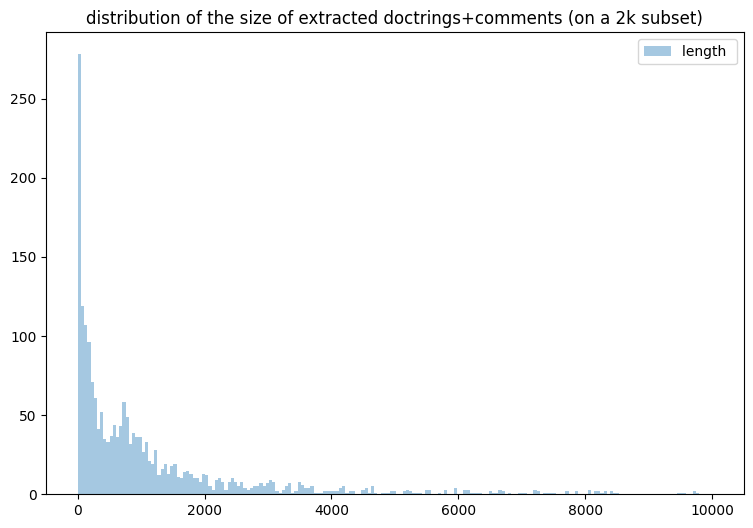

In [65]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of extracted doctrings+comments (on a 2k subset)")
# 7% of the files have empty (or almost empty) nl_text columns

Now let's identify languages

In [67]:
path_fasttext_model = "fasttext_model/lid.176.bin"
func_dataset_modifying_documents = FunctionDatasetModifyingDocuments(
    path_fasttext_model
)

In [68]:
dataset[0]["nl_text"]

'Displays a MX Dataset and associated information.\n\nShows a full (hundreds of images) dataset its metadata and a list\nof associated files with the option to show metadata of each file\nand ways to download those files.  With write permission this page\nalso allows uploading and metadata editing.\n\nSettings for this view:\nINSTALLED_APPS += ("tardis.apps.mx_views",)\nDATASET_VIEWS = [("http://synchrotron.org.au/views/dataset/full",\n                  "tardis.apps.mx_views.views.view_full_dataset"),]\n\n pagination was removed by someone in the interface but not here. need to fix. If page request (9999) is out of range, deliver last page of results. take 4 evenly spaced images from the set'

In [70]:
output = func_dataset_modifying_documents(dataset[0])

In [73]:
output.keys()

dict_keys(['repo_name', 'path', 'copies', 'size', 'content', 'license', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'])

In [72]:
print(f"detected language id is: {output['nl_language']}")
print(f"Model prediction score of the language: {output['nl_language_score']}")

detected language id is: en
Model prediction score of the language: 0.873705267906189


In [76]:
dataset[4]["nl_text"]

"-*- coding: utf-8 -*- im = cv2.imread('test.jpg') im = cv2.imread('poker5hearts.jpg') im = cv2.imread('../data/black-white-rect.png')contour.jpg 需要注意的是cv2.findContours()函数接受的参数为二值图，即黑白的（不是灰度图） 所以读取的图像要先转成灰度的，再转成二值图 ret, thresh = cv2.threshold(imgray, 0, 25, 0) ret, thresh = cv2.threshold(imgray, 0, 100, 0)src, thresh, maxval, type轮廓提取模式 Contour_Retrieval_Mode img = cv2.drawContours(im, contours, 3, (255, 0, 0), 3)"

In [77]:
output2 = func_dataset_modifying_documents(dataset[4])
print(f"detected language id is: {output2['nl_language']}")
# zh stands for Chinese
print(f"Model prediction score of the language: {output2['nl_language_score']}")

detected language id is: zh
Model prediction score of the language: 0.1867564469575882


In [ ]:
dataset[0]["nl_text"]

Now let's run language detection on the full 2,000 samples subset

In [78]:
# Could be improved by allowing multiprocessing with map (currently doesn't work)
dataset_language = dataset.map(
    func_dataset_modifying_documents, num_proc=1
)  # num_proc=cpu_count()
print("Fasttext done")

  0%|          | 0/2000 [00:00<?, ?ex/s]

Fasttext done


In [79]:
dataset_language

Dataset({
    features: ['repo_name', 'path', 'copies', 'size', 'content', 'license', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated', 'nl_text', 'nl_size', 'nl_language', 'nl_language_score'],
    num_rows: 2000
})

In [111]:
ratio = sum([1 if dataset_language["nl_language"][i] != "en" else 0 for i in range(len(dataset))])/len(dataset)
print(f"percentage of non english detected languages {ratio*100}%")

percentage of non english detected languages 3.95%


In [87]:
#languages that are'n english in the first 200 samples = 8%
L = []
for i in range(200):
    if dataset_language["nl_language"][i] != "en":
        L.append(i)
        print(i)

4
11
23
52
56
72
75
77
79
110
126
138
139
143


### successful detections

In [109]:
print(dataset_language["nl_language"][23])
print(dataset_language["nl_language_score"][23])
print(dataset_language["nl_text"][23])

de
0.8126402497291565
-*- coding: UTF-8 -*-reply.add('deine mutter hat gefailed.')return "OHFUCKOHFUCKOHFUCK Etwas lief schief! Datenbankfehler"return "Error 555!"reply.add('Deine Mutter hat die Datenbank gefressen')


In [108]:
print(dataset_language["nl_language"][52])
print(dataset_language["nl_language_score"][52])
print(dataset_language["nl_text"][52])

zh
0.2926284968852997
测试的主入口类
       接口的测试 - 主方法
       :param name: case 名称
       :param desc: case的详细描述
       :param method: GET/POST
       :param url: 调用的接口
       :param headers: h1: v1
h2: v2
       :param cookies: c1: v1
c2: v2
       :param param: key1=value1&key2=value2
       :param expect_value: 预计返回值
       :param func:assert_equal - 预计返回值和实际返回值相等/assert_in - 实际返回值包含预计返回值
       :param proxies_proxy - 代理设置
       

!/usr/bin/env python -*- coding: utf-8 -*-    Meng xiangguo <mxgnene01@gmail.com>              _____               ______     ____====  ]OO|_n_n__][.      |    |]    [________]_|__|________)<     |MENG|     oo    oo  'oo OOOO-| oo\_   ~o~~~o~' +--+--+--+--+--+--+--+--+--+--+--+--+--+                        2017/10/16  下午5:47 params 为json格式


In [107]:
print(dataset_language["nl_language"][75])
print(dataset_language["nl_language_score"][75])
print(dataset_language["nl_text"][75])

zh
0.1798248142004013
!/usr/bin/python -*- coding: utf-8 -*-statisticalArbitrageMultiple.py------------------------------继承重载函数------------------------------自定义初始化函数行情数据触发函数计算S自动保存缓存触发函数----------------------实现函数体----------------------self.sendS(S, parameter["stocks"][0], data["dateTime"], Pa, Pb)还没开仓正反已经开仓正平止损反平止损正反


In [106]:
print(dataset_language["nl_language"][77])
print(dataset_language["nl_language_score"][77])
print(dataset_language["nl_text"][77])

de
0.2548050284385681
TODO: inelegant vim: tabstop=8 expandtab shiftwidth=4 softtabstop=4


In [105]:
print(dataset_language["nl_language"][138])
print(dataset_language["nl_language_score"][138])
print(dataset_language["nl_text"][138])

zh
0.9402592182159424
-*- coding:utf-8 -*- Email Address Username password Md5 Hash Role 鍏宠仈 Role table 鐪熷疄濮撳悕 鍦板潃 职位 鍏充簬鎴� 手机号码 QQ号码 娉ㄥ唽鏃堕棿 鏈�鍚庣櫥褰曟椂闂� 璐︽埛鐘舵�� 澶村儚 杩滄帶鍗P鍦板潃 鏄惁鍒犻櫎 澶囨敞 褰曞叆浜� 褰曞叆鏃堕棿 所属业务 褰曞叆浜� 褰曞叆鏃堕棿 澶囨敞 Hostname SN 璁惧搴忓垪鍙� os绫诲瀷 鐢熶骇鍟� 鍝佺墝 鍨嬪彿 CPU 鍨嬪彿 CPU 鏍告暟 鍐呭瓨瀹归噺 所属业务 电源状态 浣跨敤鐘舵�� 浣跨敤閮ㄩ棬 閮ㄩ棬浣跨敤浜� 涓昏鐢ㄩ�� 褰曞叆浜� 褰曞叆鏃堕棿 澶囨敞 褰曞叆浜� 褰曞叆鏃堕棿 澶囨敞 褰曞叆浜� 褰曞叆鏃堕棿 澶囨敞 是否启用 褰曞叆浜� 褰曞叆鏃堕棿 澶囨敞 任务名称 脚本名称 脚本类型   python  shell  playbook  perl 系统架构   避免脚本运行出错 脚本md5码   防止被修改 脚本uuid 脚本版本 启用 录入人 录入时间 备注 设备id  通过cmdb读取设备 设备IP地址 选择设备后自动获取设备IP  在正式安装时判断是否与设备一致 系统版本 部署方式  IPMI  DHCP 任务列表   安装系统后需要执行的 录入人 录入时间 备注 录入人 录入时间 备注 录入人 录入时间 备注 录入人 录入时间 备注 对比类型,   文件或目录 录入人 录入时间 备注 录入人 录入时间 备注 录入人 录入时间 备注 命令记录 录入时间 备注 录入时间 action  [ 1: add , 2: edit, 3: del ]


In [104]:
print(dataset_language["nl_language"][143])
print(dataset_language["nl_language_score"][143])
print(dataset_language["nl_text"][143])

ru
0.3809477984905243
Партнер, авторизованный без логина/пароля (на доверии).

@ivar domain: корневой домен партнера
@type domain: L{BaseDomain}
Провайдер авторизации партнеров без логина/пароля (на доверии).

В этой ситуации доступ к СпамоБорцу ограничен с помощью других средств
(HTTP-proxy, firewall).

@ivar partner: единственный партнер, который обеспечивает весь доступ
@type partner: L{NullPartner}
Конструктор.
Конструктор.
Выполнить авторизацию партнера.

@param partner_info: информация о партнере
@return: Deferred, партнер (L{IPartner})
@rtype: C{twisted.internet.defer.Deferred} 
Получить корневой домен партнера.

@return: Deferred, корневой домен (L{IDomain})
@rtype: C{twisted.internet.defer.Deferred} 
Модуль авторизации партнеров без логинов/паролей (на доверии).

 -*- coding: utf-8 -*- SpamFighter, Copyright 2008, 2009 NetStream LLC (http://netstream.ru/, we@netstream.ru) This file is part of SpamFighter. SpamFighter is free software: you can redistribute it and/or modify it u

### failures:

In [103]:
print(dataset_language["nl_language"][79])
print(dataset_language["nl_language_score"][79])
print(dataset_language["nl_text"][79])
print("\n")
print(dataset_language["nl_language"][11])
print(dataset_language["nl_language_score"][11])
print(dataset_language["nl_text"][11])
print("\n")
print(dataset_language["nl_language"][110])
print(dataset_language["nl_language_score"][110])
print(dataset_language["nl_text"][110])
print("\n")
print(dataset_language["nl_language"][139])
print(dataset_language["nl_language_score"][139])
print(dataset_language["nl_text"][139])

fa
0.09532743692398071
Remove newlines


fr
0.2886621654033661
coding: utf-8============================================================================================================================================================================================html_doc = '<?xml version="1.0" encoding="UTF-8" ?>\n<html>' + content.encode('utf-8') + '\n</html>'==========================================================================================================================================================================================================================================================================================	==============================================================================================	============================================================================================================================================================================================ 		d	u' 30-09-2012'	unicodedate = ' 30-09-2012'=======================

In [ ]:
#distribution of langauges

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(dataset['nl_size'], bins=np.linspace(0, 10_000, 200), alpha=0.4, label="length ")
plt.legend(prop ={'size': 10})
#truncated distribution
plt.title("distribution of the size of extracted doctrings+comments (on a 2k subset)")
# 7% of the files have empty (or almost empty) nl_text columns

In [113]:
type(dataset_language["nl_language"])

list

<AxesSubplot:title={'center':'NL language distribution in Python code (2k subset)'}>

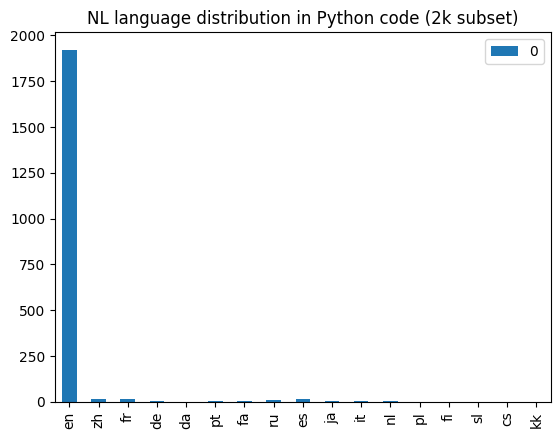

In [120]:
import pandas
from collections import Counter
letter_counts = Counter(dataset_language["nl_language"])
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar', title="NL language distribution in Python code (2k subset)")